In [154]:
# import libraries
from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor, AllChem, Descriptors, PandasTools, MolStandardize
# 環状化合物をきれいに描画 https://future-chem.com/rdkit-coordgen/
rdDepictor.SetPreferCoordGen(True)
import pandas as pd
import pubchempy as pcp
import datetime

SDFファイルを読み込み

,ID,ROMol,FASTA
0,,,WASTA
1,,,wasta

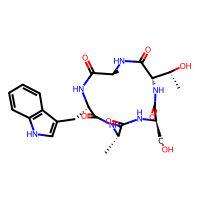
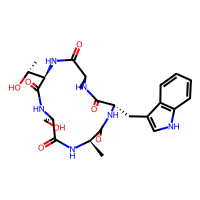

In [63]:
df = PandasTools.LoadSDF('../streamlit/WASTA_dl.sdf')
df['FASTA'] = ['WASTA', 'wasta']
df

Descriptorsのリストを作成、検索

In [31]:
DesList = pd.DataFrame(Descriptors.descList)
keyword = input('search')
print('search keyword is ' + keyword)
DesList[DesList[0].str.contains(keyword)]

rb


,0,1
108,NumAliphaticCarbocycles,<function <lambda> at 0x13f49bc70>
111,NumAromaticCarbocycles,<function <lambda> at 0x13f49b9a0>
118,NumSaturatedCarbocycles,<function <lambda> at 0x13f49bac0>
148,fr_alkyl_carbamate,<function _LoadPatterns.<locals>.<lambda> at 0...
157,fr_barbitur,<function _LoadPatterns.<locals>.<lambda> at 0...


MolファイルからDescriptorを生成

,ID,ROMol,FASTA,MW,MolLogP,TPSA,HBD,HBA,No.RB,rings
0,,,WASTA,516.555,-2.4391,201.75,8,7,4,3
1,,,wasta,516.555,-2.4391,201.75,8,7,4,3

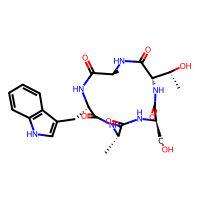
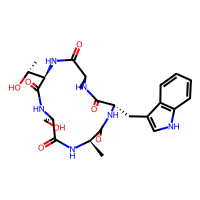

In [64]:
df['MW'] = df.ROMol.map(Descriptors.MolWt)
df['MolLogP'] = df.ROMol.map(Descriptors.MolLogP)
df['TPSA'] = df.ROMol.map(Descriptors.TPSA)
df['HBD'] = df.ROMol.map(Descriptors.NumHDonors)
df['HBA'] = df.ROMol.map(Descriptors.NumHAcceptors)
df['No.RB'] = df.ROMol.map(Descriptors.NumRotatableBonds)
df['rings'] = df.ROMol.map(AllChem.CalcNumRings)
df

smilesのリスト

In [58]:
smiles = [
    'CCCC',
    'C1=CC=CC=C1',
    'CC1=CNC2=C1C=CC=C2',
]

spaceで分割してsmiles listを作成

In [202]:
smiles = [
    'CCCC C1=CC=CC=C1 CC1=CNC2=C1C=CC=C2'
]
smiles = smiles[0].split(' ')
smiles

['CCCC', 'C1=CC=CC=C1', 'CC1=CNC2=C1C=CC=C2']

SMILESのリストからMOLファイルとDescriptorを生成

分子の確認

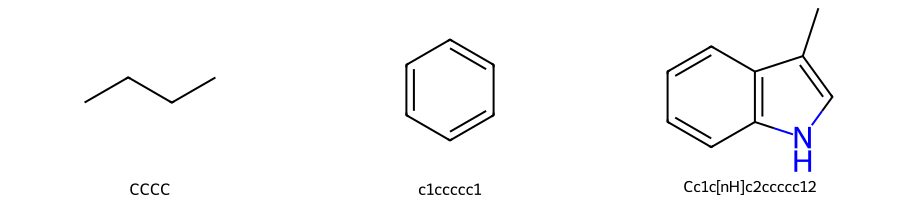

In [210]:
df = pd.DataFrame(columns=['SMILES'])
df['SMILES'] = smiles
df['ROMol'] = df.SMILES.map(lambda x: Chem.MolFromSmiles(x))
df['SMILES'] = df.ROMol.map(lambda x: Chem.MolToSmiles(x))
df['MW'] = df.ROMol.map(Descriptors.MolWt)
df['MolLogP'] = df.ROMol.map(Descriptors.MolLogP)
df['TPSA'] = df.ROMol.map(Descriptors.TPSA)
df['HBD'] = df.ROMol.map(Descriptors.NumHDonors)
df['HBA'] = df.ROMol.map(Descriptors.NumHAcceptors)
df['No.RB'] = df.ROMol.map(Descriptors.NumRotatableBonds)
df['rings'] = df.ROMol.map(AllChem.CalcNumRings)
df['Ar'] = df.ROMol.map(Descriptors.NumAromaticRings)
Draw.MolsToGridImage(df.ROMol,
                     molsPerRow=3,
                     subImgSize=(300,200),
                     legends= list(df.SMILES),
                     useSVG=True
                     )

Propertyの表示

In [211]:
df.T

,0,1,2
SMILES,CCCC,c1ccccc1,Cc1c[nH]c2ccccc12
ROMol,<rdkit.Chem.rdchem.Mol object at 0x1515f4820>,<rdkit.Chem.rdchem.Mol object at 0x1515f5230>,<rdkit.Chem.rdchem.Mol object at 0x1515f51c0>
MW,58.124,78.114,131.178
MolLogP,1.8064,1.6866,2.47632
TPSA,0.0,0.0,15.79
HBD,0,0,1
HBA,0,0,0
No.RB,1,0,0
rings,0,1,2
Ar,0,1,2


三次元化した分子の確認

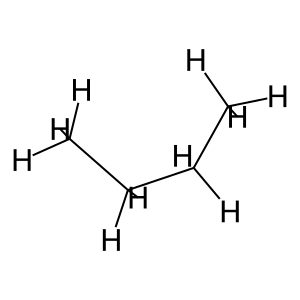

In [212]:
# generate 3D conformations
df['ROMol'] = df['ROMol'].map(lambda x:Chem.AddHs(x))
df['3d'] = df['ROMol'].map(lambda x:AllChem.EmbedMolecule(x))
df['opt'] = df['ROMol'].map(lambda x:AllChem.UFFOptimizeMolecule(x))
Draw.MolToImage(df['ROMol'].iloc[0])


三次元化してsdfを保存

In [213]:
# 日付の取得
dt_now = datetime.datetime.now()
today = dt_now.strftime('%Y%m%d')

# sdfを保存
file_name = '_' + input('file name?')
Chem.PandasTools.WriteSDF(df,
    today + file_name + '.sdf',
    properties = df.columns
)


分子名を指定してPubChemからIsomeric SMILESを取得してDescriptorを生成

分子を確認

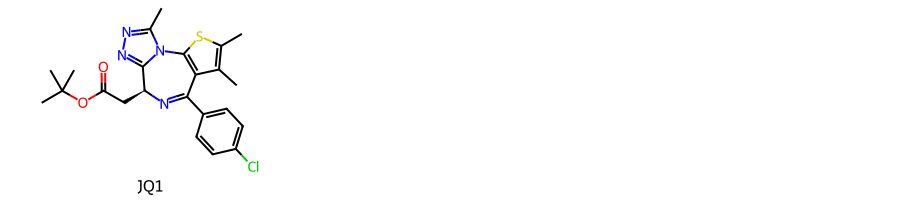

In [144]:
mol = input('Molecule Name?')
# mol = 'deucravacitinib'
df = pd.DataFrame(columns=['name', 'SMILES'])
df['name'] = [mol]
df['SMILES'] = pcp.get_properties('IsomericSMILES', mol, 'name')[0]['IsomericSMILES']
df['ROMol'] = df.SMILES.map(lambda x: Chem.MolFromSmiles(x))
Draw.MolsToGridImage(df.ROMol,
                     molsPerRow=3,
                     subImgSize=(300,200),
                     legends= list(df.name),
                     useSVG=True
                     )

Descriptorを表示

In [100]:
df['ROMol'] = df.SMILES.map(lambda x: Chem.MolFromSmiles(x))
df['SMILES'] = df.ROMol.map(lambda x: Chem.MolToSmiles(x))
df['MW'] = df.ROMol.map(Descriptors.MolWt)
df['MolLogP'] = df.ROMol.map(Descriptors.MolLogP)
df['TPSA'] = df.ROMol.map(Descriptors.TPSA)
df['HBD'] = df.ROMol.map(Descriptors.NumHDonors)
df['HBA'] = df.ROMol.map(Descriptors.NumHAcceptors)
df['No.RB'] = df.ROMol.map(Descriptors.NumRotatableBonds)
df['rings'] = df.ROMol.map(AllChem.CalcNumRings)
df['Ar'] = df.ROMol.map(Descriptors.NumAromaticRings)
df.T

,0
name,JQ1
SMILES,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OC(C...
ROMol,<rdkit.Chem.rdchem.Mol object at 0x14edeaf10>
MW,456.999
MolLogP,5.53136
TPSA,69.37
HBD,0
HBA,7
No.RB,3
rings,4


CASのリストから化合物情報を取得

CASのリスト

In [116]:
cas = [
    '100-21-0',
    '1002-62-6',
    '10028-15-6',
]

spaceで分割してsmiles listを作成

In [216]:
cas_list = [
    '110-85-0 100-21-0 1002-62-6 10028-15-6 1002-84-2 1002-89-7 999-99-9'
]
cas_list = cas_list[0].split(' ')
cas_list

['110-85-0',
 '100-21-0',
 '1002-62-6',
 '10028-15-6',
 '1002-84-2',
 '1002-89-7',
 '999-99-9']

DataFrame作成

In [217]:
df = pd.DataFrame()
properties = [
    'MolecularFormula', 
    'MolecularWeight', 
    'IsomericSMILES', 
    'IUPACName',
]
for cas in cas_list:
    try:
        temp = pcp.get_properties(properties, cas, 'name',as_dataframe=True)
        #as_dataframe=True とすることでpandas dataframe として情報を取得可能
        temp['CAS'] = cas
        df = pd.concat([df,temp],axis=0,join='outer',sort=True)
    except:
        pass
#pubchem に情報のない化合物はエラーとなるので、エラーが発生しても途中で終了させずに処理を継続できるようにtry文を使用
df['ROMol'] = df.IsomericSMILES.map(lambda x: Chem.MolFromSmiles(x))
df

,CAS,IUPACName,IsomericSMILES,MolecularFormula,MolecularWeight,ROMol
CID,,,,,,
4837,110-85-0,piperazine,C1CNCCN1,C4H10N2,86.14,<rdkit.Chem.rdchem.Mol object at 0x151b4f300>
7489,100-21-0,terephthalic acid,C1=CC(=CC=C1C(=O)O)C(=O)O,C8H6O4,166.13,<rdkit.Chem.rdchem.Mol object at 0x151b4f450>
4457968,1002-62-6,sodium;decanoate,CCCCCCCCCC(=O)[O-].[Na+],C10H19NaO2,194.25,<rdkit.Chem.rdchem.Mol object at 0x151b4f4c0>
24823,10028-15-6,ozone,[O-][O+]=O,O3,47.998,<rdkit.Chem.rdchem.Mol object at 0x151b4f290>
13849,1002-84-2,pentadecanoic acid,CCCCCCCCCCCCCCC(=O)O,C15H30O2,242.40,<rdkit.Chem.rdchem.Mol object at 0x151b4f220>
9861187,1002-89-7,azanium;octadecanoate,CCCCCCCCCCCCCCCCCC(=O)[O-].[NH4+],C18H39NO2,301.5,<rdkit.Chem.rdchem.Mol object at 0x151b4f1b0>


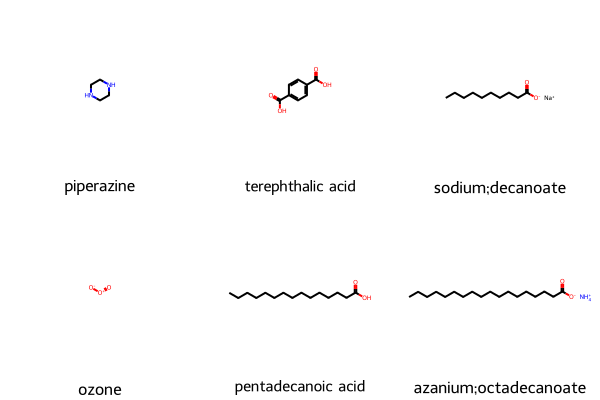

In [218]:
Draw.MolsToGridImage(df['ROMol'],
                     molsPerRow=3,
                     legends= list(df.IUPACName)
                     )

分子の前処理

大きいフラグメントだけ残す

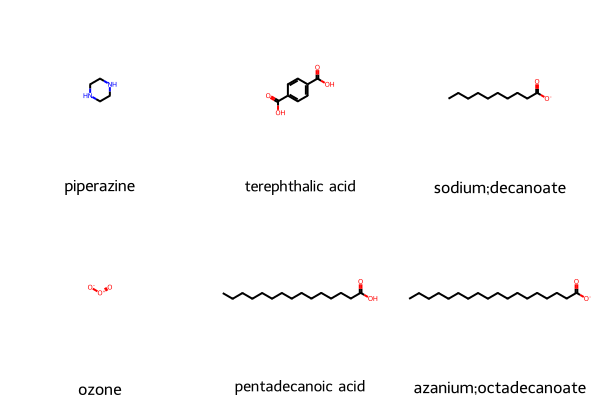

In [219]:
lfc = MolStandardize.fragment.LargestFragmentChooser()
df['ROMol'] = df.ROMol.map(lambda x: lfc.choose(x))
Draw.MolsToGridImage(df['ROMol'],
                     molsPerRow=3,
                     legends= list(df.IUPACName)
                     )

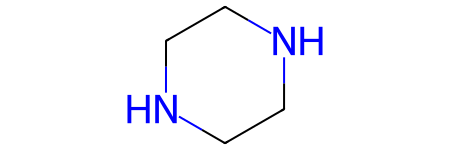

In [221]:
from rdkit.Chem import MolStandardize
pip = df['ROMol'].iloc[0]
normalizer= MolStandardize.normalize.Normalizer()
normalizer.normalize(pip)

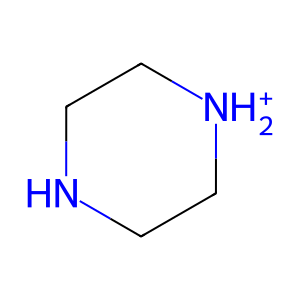

In [225]:
piperazine = Chem.MolFromSmiles('C1CNCC[NH2+]1')
Draw.MolToImage(piperazine)

部分構造検索

In [149]:
match = 'C1=CC=CC=C1'
match = Chem.MolFromSmiles(match)
df[df.ROMol >= match]

,CAS,IUPACName,IsomericSMILES,MolecularFormula,MolecularWeight,ROMol
CID,,,,,,
7489,100-21-0,terephthalic acid,C1=CC(=CC=C1C(=O)O)C(=O)O,C8H6O4,166.13,<rdkit.Chem.rdchem.Mol object at 0x1515bbae0>


三次元化してsdfを保存

In [191]:
# generate 3D conformations
df['ROMol'] = df['ROMol'].map(lambda x:Chem.AddHs(x))
df['3d'] = df['ROMol'].map(lambda x:AllChem.EmbedMolecule(x))
df['opt'] = df['ROMol'].map(lambda x:AllChem.UFFOptimizeMolecule(x))

# 日付の取得
dt_now = datetime.datetime.now()
today = dt_now.strftime('%Y%m%d')

# sdfを保存
file_name = '_' + input('file name?')
Chem.PandasTools.WriteSDF(df,
    today + file_name + '.sdf',
    properties = ['SMILES']
)


,name,SMILES,ROMol,3d,opt
0,deucravacitinib,[2H]C([2H])([2H])NC(=O)C1=NN=C(C=C1NC2=CC=CC(=...,<rdkit.Chem.rdchem.Mol object at 0x151a5d070>,0,1


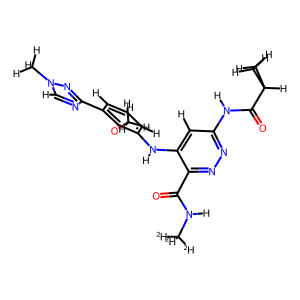

In [192]:
Draw.MolToImage(df['ROMol'].iloc[0])